<a href="https://colab.research.google.com/github/020/020.github.io/blob/master/Power_Consumption_Hourly_TS_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from prophet import Prophet
from xgboost import XGBRegressor

In [3]:
df = pd.read_csv('/content/DAYTON_hourly.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121275 entries, 0 to 121274
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Datetime   121275 non-null  object 
 1   DAYTON_MW  121275 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [7]:
# Set color style
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['#cc444b', '#e89005'])

In [14]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True, drop=True)
df.head()

,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1596.0
2004-12-31 02:00:00,1517.0
2004-12-31 03:00:00,1486.0
2004-12-31 04:00:00,1469.0
2004-12-31 05:00:00,1472.0


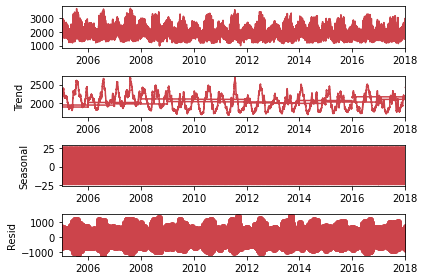

In [15]:
seasonal_decompose(df, period=365).plot()
plt.show()

In [17]:
# Daily Consumption
ma = df.resample('D').mean()

# 3 Day Example
ma['Moving Average'] = ma['DAYTON_MW'].rolling(3).mean()
ma.head()

,DAYTON_MW,Moving Average
Datetime,,
2004-10-01,1924.130435,NaN
2004-10-02,1641.583333,NaN
2004-10-03,1528.708333,1698.140700
2004-10-04,1926.541667,1698.944444
2004-10-05,1970.125000,1808.458333


In [18]:
def moving_average(data, window):
   data['Moving Average'] = data['DAYTON_MW'].rolling(window).mean()
   actual = data['DAYTON_MW'][-(window+30):]
   ma = data['Moving Average'][-(window+30):]

   plt.figure(figsize=(20,8))
   actual.plot(label='Actual', lw=4)
   ma.plot(label='MA-{}'.format(str(window)), ls='--', lw=2)
   plt.title('{}-Days Moving Average'.format(str(window)), weight='bold', fontsize=25)
   plt.legend()

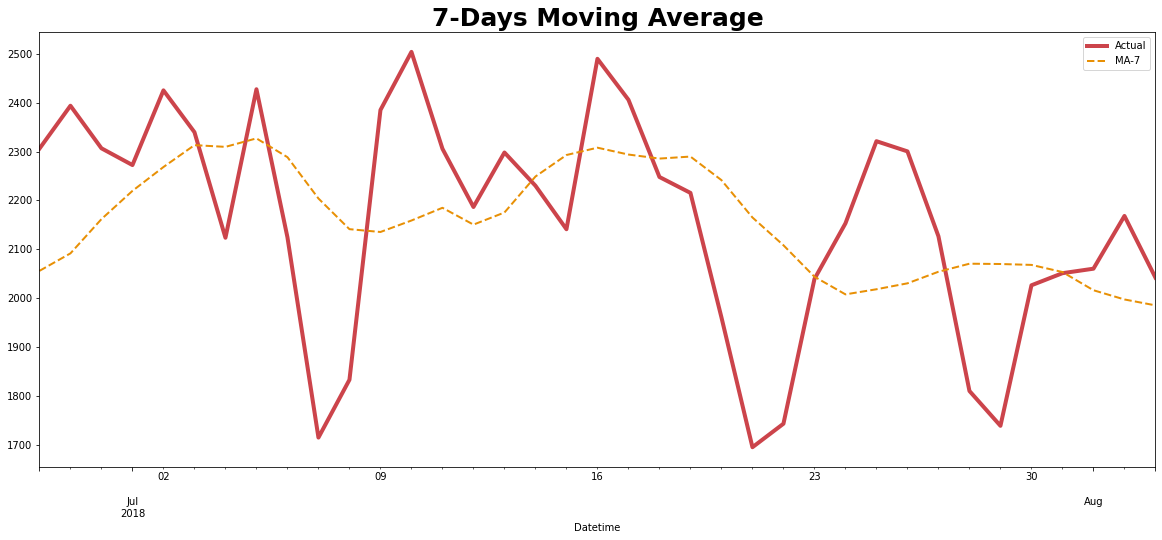

In [19]:
moving_average(ma, 7)

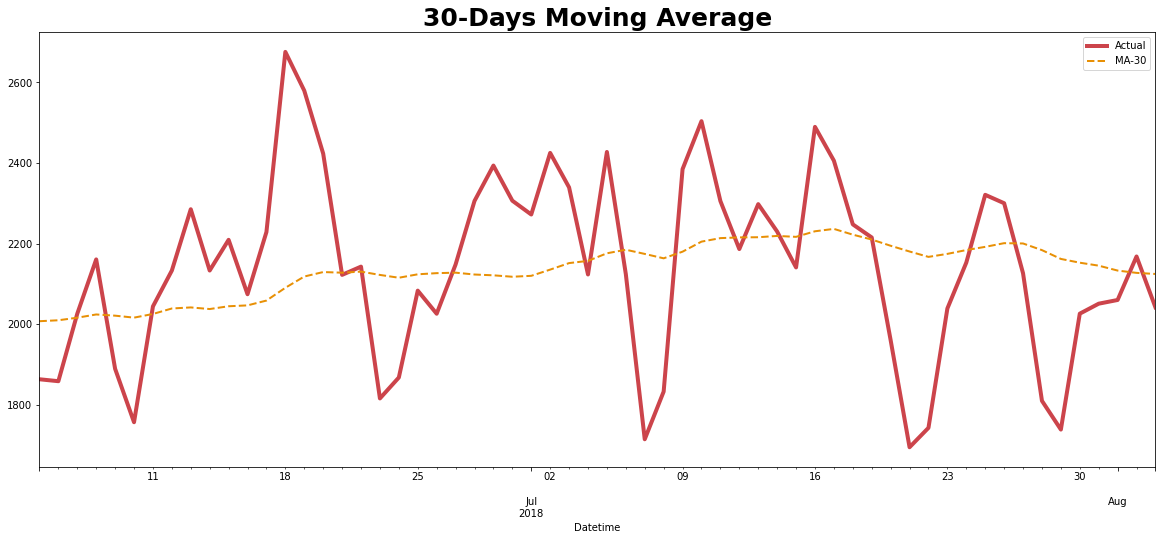

In [20]:
moving_average(ma, 30)

In [22]:
df_train, df_test = df[df.index < '2016-01-01'], df[df.index >= '2016-01-01']

print('Train:\t', len(df_train))
print('Test:\t', len(df_test))

Train:	 98595
Test:	 22680


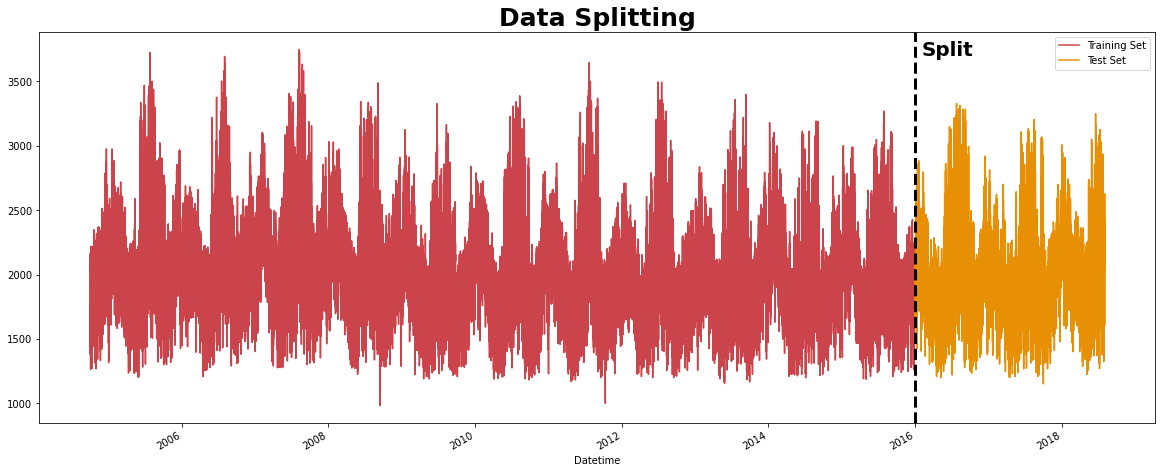

In [24]:
plt.figure(figsize=(20,8))

df_train['DAYTON_MW'].plot(label='Training Set')
df_test['DAYTON_MW'].plot(label='Test Set')
plt.axvline('2016-01-01', color='black', ls='--', lw=3)
plt.text('2016-02-01', 3700, 'Split', fontsize=20, fontweight='bold')
plt.title('Data Splitting', weight='bold', fontsize=25)
plt.legend()

In [25]:
def index_to_column(data):
    data = data.reset_index()
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data = data.sort_values('Datetime')

    data = data.rename(columns={'Datetime': 'ds', 'DAYTON_MW': 'y'})
    return data

In [26]:
prophet_train = index_to_column(df_train)
prophet_test = index_to_column(df_test)

In [27]:
prophet_model = Prophet(interval_width=0.95)

prophet_model.fit(prophet_train)
prophet_pred = prophet_model.predict(prophet_test[['ds']])
#Keep the dataset format

DEBUG:cmdstanpy:input tempfile: /tmp/tmph1xcmsi8/vkmf50jy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1xcmsi8/tsbw3ph_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42371', 'data', 'file=/tmp/tmph1xcmsi8/vkmf50jy.json', 'init=/tmp/tmph1xcmsi8/tsbw3ph_.json', 'output', 'file=/tmp/tmpzffxeo02/prophet_model-20220823000024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:00:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:02:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


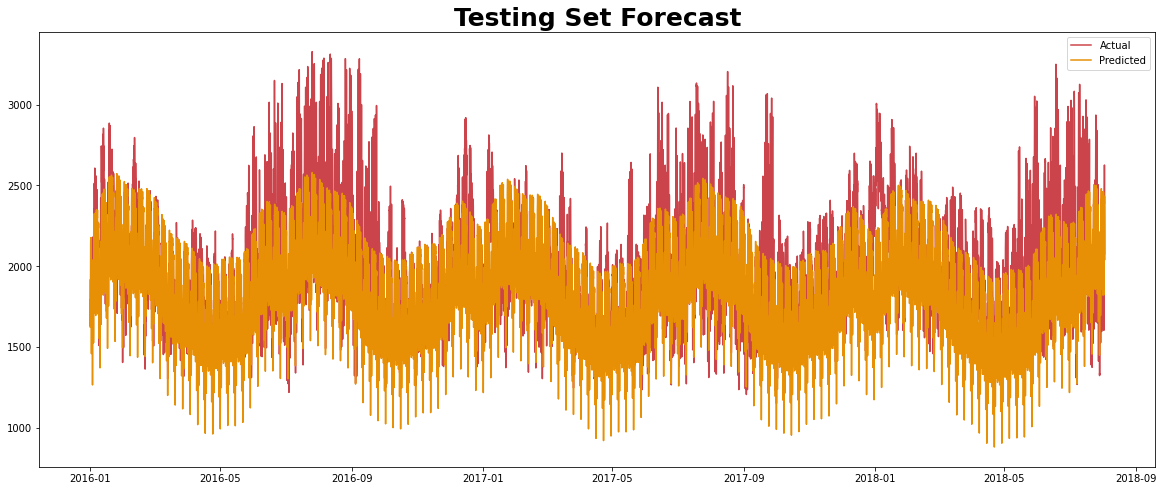

In [40]:
mae = round(mean_absolute_error(prophet_test['y'], prophet_pred['yhat']), 3)

plt.figure(figsize=(20,8))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicted')
plt.title('Test Forecasting', weight='bold', fontsize=40)
#plt.text(10, 10, 'MAE: {}'.format(mae), fontsize=15, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()

In [41]:
# This time, we will use all data (train and test) to train our model
new_df = index_to_column(df)

In [43]:
prophet_model2 = Prophet(interval_width=0.95)
prophet_model2.fit(new_df)
# 7 days to the future (7x24 = 168)
future_dates = prophet_model2.make_future_dataframe(periods=168, freq='H')
prophet_pred2 = prophet_model2.predict(future_dates)


DEBUG:cmdstanpy:input tempfile: /tmp/tmph1xcmsi8/131z40a6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1xcmsi8/n5k1yy52.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30697', 'data', 'file=/tmp/tmph1xcmsi8/131z40a6.json', 'init=/tmp/tmph1xcmsi8/n5k1yy52.json', 'output', 'file=/tmp/tmpi8z08t3h/prophet_model-20220823004224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:42:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:45:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1440x576 with 0 Axes>

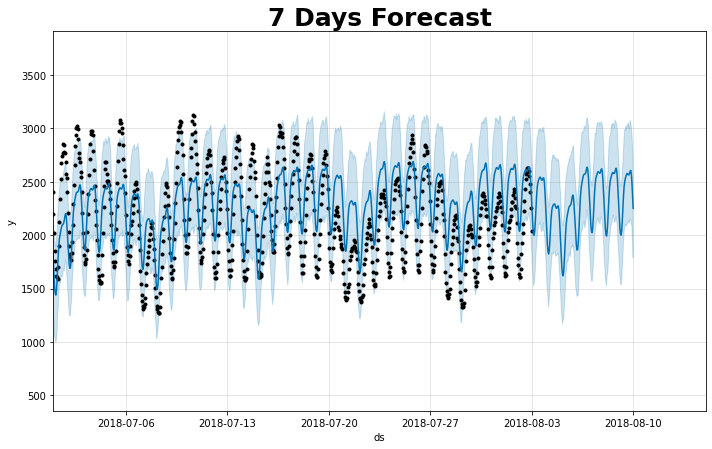

In [47]:
plt.figure(figsize=(20,8))

fig = prophet_model2.plot(prophet_pred2, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2018-07-01', '2018-08-15']))
plt.title('7 Days Forecast', weight='bold', fontsize=25)
plt.show()

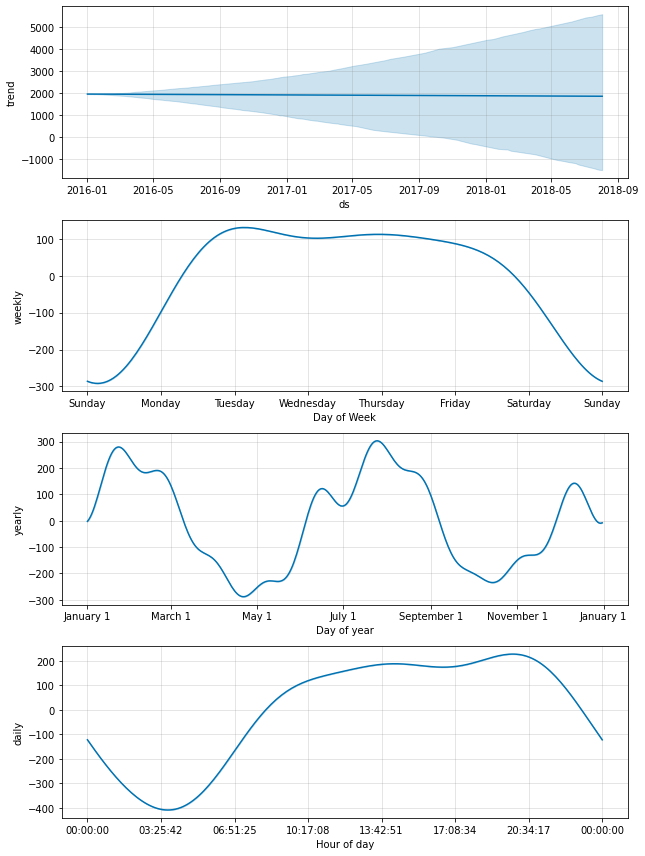

In [48]:
prophet_model.plot_components(prophet_pred)
plt.show()

In [51]:
def date_transform(data):
    df = data.copy()

    df['Hour'] = df.index.hour
    df['Dayofweek'] = df.index.dayofweek
    df['Dayofmonth'] = df.index.day
    df['Dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.weekofyear
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year

    X = df.drop('DAYTON_MW', axis=1)
    y = df['DAYTON_MW']

    return X, y

In [52]:
X_train, y_train = date_transform(df_train)
X_test, y_test = date_transform(df_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [59]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10)
xgb_model.fit(X_train, y_train, eval_metric='mae', eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_pred = xgb_model.predict(X_test)

[01:04:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:1940.23	validation_1-mae:1912.89
[1]	validation_0-mae:1843.38	validation_1-mae:1815.56
[2]	validation_0-mae:1751.13	validation_1-mae:1722.77
[3]	validation_0-mae:1663.7	validation_1-mae:1636.51
[4]	validation_0-mae:1580.27	validation_1-mae:1552.68
[5]	validation_0-mae:1501.22	validation_1-mae:1474.84
[6]	validation_0-mae:1426.11	validation_1-mae:1401
[7]	validation_0-mae:1355.09	validation_1-mae:1329.28
[8]	validation_0-mae:1287.22	validation_1-mae:1262.3
[9]	validation_0-mae:1222.92	validation_1-mae:1197.97
[10]	validation_0-mae:1161.65	validation_1-mae:1136.38
[11]	validation_0-mae:1103.69	validation_1-mae:1078.52
[12]	validation_0-mae:1048.47	validation_1-mae:1023.35
[13]	validation_0-mae:996.061	validation_1-mae:972.194
[14]	validation_0-mae:946.257	validation_1-mae:922.702
[15]	validation_0-mae:898.849	validation_1-mae:875.061
[16]	val

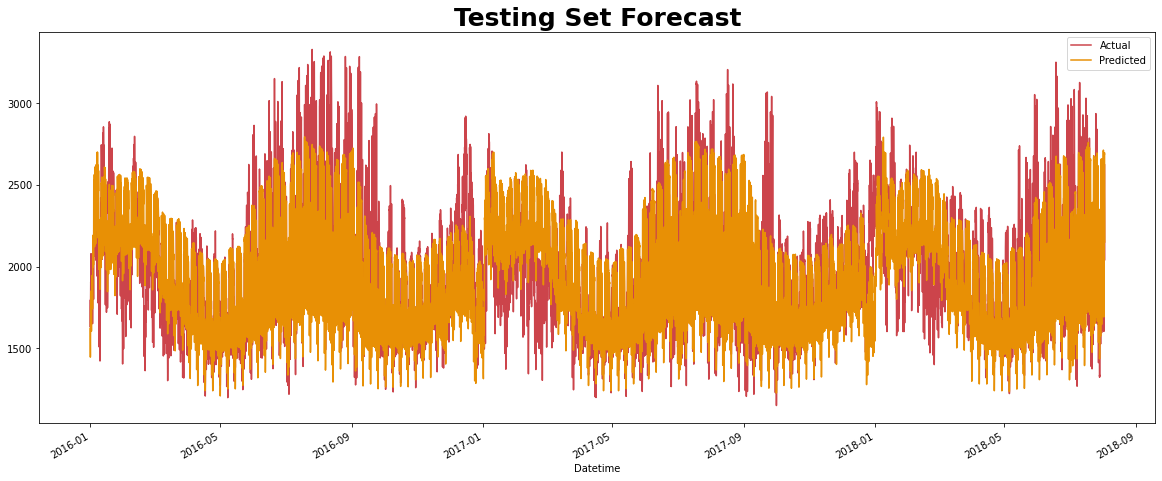

In [60]:
mae = round(mean_absolute_error(y_test, xgb_pred), 3)

df_plot = pd.DataFrame({'y_test':y_test, 'xgb_pred':xgb_pred})

plt.figure(figsize=(20, 8))

df_plot['y_test'].plot(label='Actual')
df_plot['xgb_pred'].plot(label='Predicted')
#plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

In [61]:
mae

183.607

In [62]:
future_dates2 = future_dates.iloc[-168:, :].copy()

future_dates2['ds'] = pd.to_datetime(future_dates2['ds'])
future_dates2 = future_dates2.set_index('ds')

future_dates2['Hour'] = future_dates2.index.hour
future_dates2['Dayofweek'] = future_dates2.index.dayofweek
future_dates2['Dayofmonth'] = future_dates2.index.day
future_dates2['Dayofyear'] = future_dates2.index.dayofyear
future_dates2['weekofyear'] = future_dates2.index.weekofyear
future_dates2['Month'] = future_dates2.index.month
future_dates2['Quarter'] = future_dates2.index.quarter
future_dates2['Year'] = future_dates2.index.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  # Remove the CWD from sys.path while we load stuff.


In [63]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

In [64]:
xgb_model2 = XGBRegressor(n_estimators=100, learning_rate=0.05)
xgb_model2.fit(X, y, eval_metric='mae')
xgb_pred2 = xgb_model2.predict(future_dates2)

[01:09:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


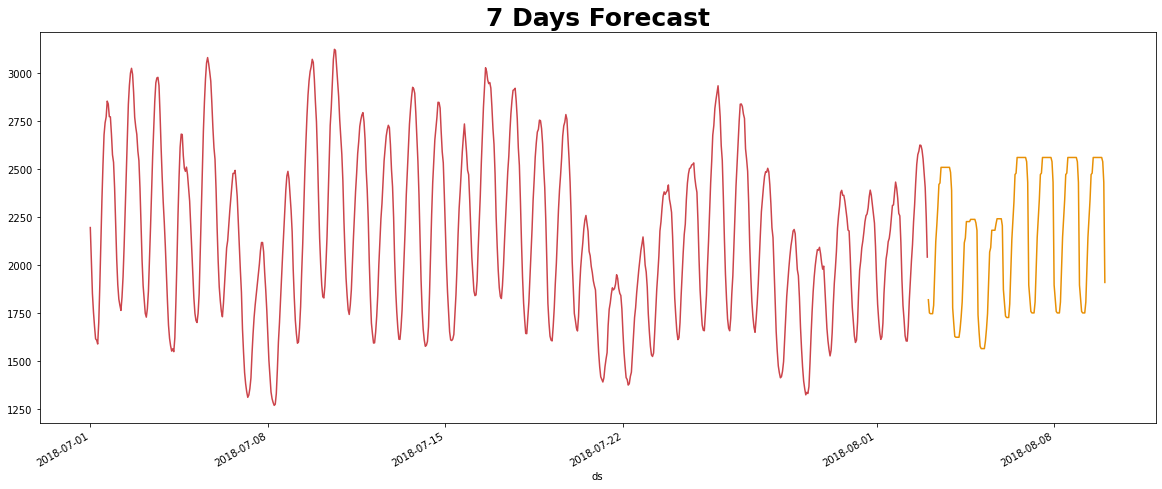

In [66]:
df_plot2 = pd.DataFrame({'Hour':future_dates2['Hour'], 'xgb_pred2' :xgb_pred2})

last_week = df['2018-07-01':'2018-08-15']

plt.figure(figsize=(20,8))

last_week['DAYTON_MW'].plot()
df_plot2['xgb_pred2'].plot()
plt.title('7 Days Forecast', weight='bold', fontsize=25)
plt.show()

In [68]:
dataset = tf.expand_dims(df_train['DAYTON_MW'].head(10), axis=-1)

# Generate a tf datset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

#Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

#Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

#Create tuples with features  (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# Shuffle the windows
#dataset = dataset.shuffle(buffer_size=10)

#Create batches of windows
#dataset = dataset.batch(2).prefetch(1)

#Print the results
for x, y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()


x =  [[1596.]
 [1517.]
 [1486.]
 [1469.]]
y =  [1472.]

x =  [[1517.]
 [1486.]
 [1469.]
 [1472.]]
y =  [1518.]

x =  [[1486.]
 [1469.]
 [1472.]
 [1518.]]
y =  [1598.]

x =  [[1469.]
 [1472.]
 [1518.]
 [1598.]]
y =  [1691.]

x =  [[1472.]
 [1518.]
 [1598.]
 [1691.]]
y =  [1748.]

x =  [[1518.]
 [1598.]
 [1691.]
 [1748.]]
y =  [1825.]



In [71]:
def windowing(data, window_size, shuffle_buffer, batch_size):
  dataset = tf.expand_dims(data, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(dataset)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True) #window size = 24 + 1 (test)
  dataset = dataset.flat_map(lambda window: window.batch (window_size+1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [72]:
train = windowing(df_train['DAYTON_MW'], 24, 72, 32)
test = windowing(df_test['DAYTON_MW'], 24, 72, 32)

In [73]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=[24, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 16)            64        
                                                                 
 bidirectional (Bidirectiona  (None, 32)               4224      
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [74]:
dnn_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
3081/3081 [==============================] - 81s 25ms/step - loss: 92.7965 - val_loss: 61.4681
Epoch 2/20
3081/3081 [==============================] - 79s 26ms/step - loss: 66.4681 - val_loss: 52.0319
Epoch 3/20
3081/3081 [==============================] - 78s 25ms/step - loss: 50.0690 - val_loss: 55.6010
Epoch 4/20
3081/3081 [==============================] - 77s 25ms/step - loss: 47.4395 - val_loss: 44.9357
Epoch 5/20
3081/3081 [==============================] - 75s 24ms/step - loss: 43.8617 - val_loss: 41.5479
Epoch 6/20
3081/3081 [==============================] - 74s 24ms/step - loss: 41.9685 - val_loss: 42.9038
Epoch 7/20
3081/3081 [==============================] - 76s 25ms/step - loss: 40.6576 - val_loss: 41.8686
Epoch 8/20
3081/3081 [==============================] - 74s 24ms/step - loss: 39.8731 - val_loss: 49.9348
Epoch 9/20
3081/3081 [==============================] - 75s 24ms/step - loss: 38.5465 - val_loss: 48.1421
Epoch 10/20
3081/3081 [=======================

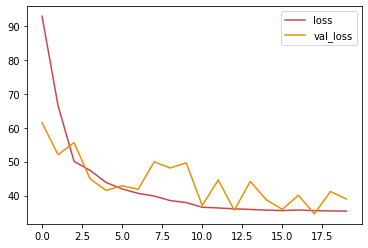

In [75]:
metric = pd.DataFrame(dnn_model.history.history)
metric.plot() 

In [76]:
window_size = 24
forecast = []

train_length = len(df_train)
forecast_series = df[train_length - window_size:]

#Use the model to predict data pints per window size

for time in range(len(forecast_series) - window_size):
  forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

results = np.array(forecast).squeeze()

In [78]:
mae = round(mean_absolute_error(df_test['DAYTON_MW'], df_test['Pred']), 3)

df_test['Pred'] = results

plt.figure(figsize=(20,8))

df_test['DAYTON_MW'].plot(label='Actual')
df_test['Pred'].plot(label='Predicted')
plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

KeyError: ignored